In [17]:
import sys
import jax.numpy as jnp
import numpy as np
import optax
from jax import random, jit, vjp, grad, vmap
import jax.flatten_util as flat_utl
from jax.experimental.host_callback import call
from tensorflow_probability.substrates import jax as tfp
from pyDOE import lhs
import functools
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Neural Network Functions

In [2]:
# initialize the neural network weights and biases
# NN is a list of tuples containing weight/bias list pairs for each layer of the NN
def init_MLP(parent_key, layer_widths):
    params = []
    keys = random.split(parent_key, num=len(layer_widths) - 1)
    # create the weights and biases for the network
    for in_dim, out_dim, key in zip(layer_widths[:-1], layer_widths[1:], keys):
        weight_key, bias_key = random.split(key)
        xavier_stddev = jnp.sqrt(2 / (in_dim + out_dim))
        params.append(
            [random.truncated_normal(weight_key, -2, 2, shape=(in_dim, out_dim)) * xavier_stddev,
             random.truncated_normal(bias_key, -2, 2, shape=(out_dim,)) * xavier_stddev]
        )
    return params


# define the basic formation of neural network
def neural_net(params, z, limit, scl, act_s=0):
    '''
    :param params: weights and biases
    :param x: input data [matrix with shape [N, m]]; m is number of inputs)
    :param limit: characteristic scale for normalizeation [matrx with shape [2, m]]
    :param sgn:  1 for even function and -1 for odd function
    :return: neural network output [matrix with shape [N, n]]; n is number of outputs)
    '''
    lb = limit[0]  # lower bound for each input
    ub = limit[1]  # upper bound for each input

    # choose the activation function
    actv = [jnp.tanh, jnp.sin][act_s]
    # normalize the input
    H = 2.0 * (z - lb) / (ub - lb) - 1.0
    # separate the first, hidden and last layers
    first, *hidden, last = params
    # calculate the first layers output with right scale
    H = actv(jnp.dot(H, first[0]) * scl + first[1])
    # calculate the middle layers output
    for layer in hidden:
        H = jnp.tanh(jnp.dot(H, layer[0]) + layer[1])
    # no activation function for last layer 
    var = jnp.dot(H, last[0]) + last[1]
    return var

# generate weights and biases for all variables of CLM problem
def sol_init_MLP(parent_key, n_hl, n_unit):
    '''
    :param n_hl: number of hidden layers [int]
    :param n_unit: number of units in each layer [int]
    '''
    layers = [1] + n_hl * [n_unit] + [1]
    # generate the random key for each network
    keys = random.split(parent_key, 1)
    # generate weights and biases for
    params_u = init_MLP(keys[0], layers)
    return dict(net_u=params_u)


# wrapper to create solution function with given domain size
def sol_pred_create(limit, scl, act_s=0):
    '''
    :param limit: domain size of the input
    :return: function of the solution (a callable)
    '''
    def f_u(params, z):
        # generate the NN
        u = neural_net(params['net_u'], z, limit, scl, act_s)
        return u
    return f_u

def mNN_pred_create(f_u, limit, scl, epsil, act_s=0):
    '''
    :param f_u: sum of previous stage network
    :param limit: domain size of the input
    :return: function of the solution (a callable)
    '''
    def f_comb(params, z):
        # generate the NN
        u_now = neural_net(params['net_u'], z, limit, scl, act_s)
        u = f_u(z) + epsil * u_now
        return u
    return f_comb

## Lower-level PINN Functions

In [3]:
# generate matrix required for vjp for vector gradient
def vgmat(z, n_out, idx=None):
    '''
    :param n_out: number of output variables
    :param idx: indice (list) of the output variable to take the gradient
    '''
    if idx is None:
        idx = range(n_out)
    # obtain the number of index
    n_idx = len(idx)
    # obtain the number of input points
    n_pt = z.shape[0]
    # determine the shape of the gradient matrix
    mat_shape = [n_idx, n_pt, n_out]
    # create the zero matrix based on the shape
    mat = jnp.zeros(mat_shape)
    # choose the associated element in the matrix to 1
    for l, ii in zip(range(n_idx), idx):
        mat = mat.at[l, :, ii].set(1.)
    return mat


# vector gradient of the output wrt input
def vectgrad(func, z):
    # obtain the output and the gradient function
    sol, vjp_fn = vjp(func, z)
    # determine the mat grad
    mat = vgmat(z, sol.shape[1])
    # calculate the gradient of each output with respect to each input
    grad_sol = vmap(vjp_fn, in_axes=0)(mat)[0]
    # calculate the total partial derivative of output with input
    n_pd = z.shape[1] * sol.shape[1]
    # reshape the derivative of output wrt input
    grad_all = grad_sol.transpose(1, 0, 2).reshape(z.shape[0], n_pd)
    return grad_all, sol

## Target Function

In [4]:
# For the example function: du/dx = u + x, u(0) = 0

# governing equation
def gov_eqn(f_u, x):
    # calculate the output and its derivative with original coordinates
    u_x, u = vectgrad(f_u, x)
    # calculate the residue of the CCF equation
    f = u_x - (u+x)
    return f

def gov_d3_eqn(f_u, z):
    # allocate the value to each variable
    fc_res = lambda z: gov_eqn(f_u, z)
    # calculate the residue of higher derivative of CCF equation
    dfunc = lambda z: vectgrad(fc_res, z)[0]
    # calculate the residue of the first and second derivative of CCF equation
    d2f, df = vectgrad(dfunc, z)
    return df, d2f

# used for plotting vs exact solution
def fg(x):
    u = jnp.exp(x) - x - 1
    return u

## Loss/Optimization Functions

In [9]:
# define the mean squared error
def ms_error(diff):
    return jnp.mean(jnp.square(diff), axis=0)

def loss_create(predf_u, cond, lw, loss_ref):
    '''
    a function factory to create the loss function based on given info
    :param loss_ref: loss value at the initial of the training
    :return: a loss function (callable)
    '''

    # loss function used for the PINN training
    def loss_fun(params, data):
        # create the function for gradient calculation involves input Z only
        f_u = lambda z: predf_u(params, z)
        # load the data of normalization condition
        z_nm = cond['cond_nm'][0]
        u_nm = cond['cond_nm'][1]

        # load the position and weight of collocation points
        z_col = data['z_col']

        # calculate the gradient of phi at origin
        u_nm_p = f_u(z_nm)

        # calculate the residue of equation
        f = gov_eqn(f_u, z_col)
        # calculate the residue of first and second derivative
        df, d2f = gov_d3_eqn(f_u, z_col)

        # calculate the mean squared root error of normalization cond.
        norm_err = ms_error(u_nm_p - u_nm)
        # calculate the error of far-field exponent cond.
        data_err = jnp.hstack([norm_err])

        # calculate the mean squared root error of equation
        eqn_err_f = ms_error(f)
        eqn_err_df = ms_error(df)
        eqn_err_d2f = ms_error(d2f)
        eqn_err = jnp.hstack([eqn_err_f, eqn_err_df])

        # set the weight for each condition and equation
        data_weight = jnp.array([1.])
        eqn_weight = jnp.array([1., lw[1]])

        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err * data_weight)
        loss_eqn = jnp.sum(eqn_err * eqn_weight)

        # calculate the total loss
        loss = (loss_data + lw[0] * loss_eqn) / loss_ref
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn]),
                                data_err, eqn_err])
        return loss, loss_info
    return loss_fun


# create the Adam minimizer 
@functools.partial(jit, static_argnames=("lossf", "opt"))
def adam_minimizer(lossf, params, data, opt, opt_state):
    """Basic gradient update step based on the opt optimizer."""
    grads, loss_info = grad(lossf, has_aux=True)(params, data)
    updates, opt_state = opt.update(grads, opt_state)
    new_params = optax.apply_updates(params, updates)
    return new_params, loss_info, opt_state


def adam_optimizer(lossf, params, dataf, epoch, lr=1e-3):
    # select the Adam as the minimizer
    opt_Adam = optax.adam(learning_rate=lr)
    # obtain the initial state of the params
    opt_state = opt_Adam.init(params)
    # pre-allocate the loss varaible
    loss_all = []
    data = dataf()
    nc = jnp.int32(jnp.round(epoch / 5))
    nc0 = 2500
    # start the training iteration
    for step in range(epoch):
        # minimize the loss function using Adam
        params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
        # print the loss for every 100 iteration
        if step % 100 == 0:
            print(f"Step: {step} | Loss: {loss_info[0]:.4e} |"
                  f" Loss_d: {loss_info[1]:.4e} | Loss_e: {loss_info[2]:.4e}", file=sys.stderr)
            data = dataf()

        # saving the loss 
        loss_all.append(loss_info[0:])

        if (step+1) % (2*nc0) == 0:
            lossend = np.array(loss_all[-2 * nc0:])[:, 0]
            lc1 = lossend[0: nc0]
            lc2 = lossend[nc0:]
            mm12 = jnp.abs(jnp.mean(lc1) - jnp.mean(lc2))
            stdl2 = jnp.std(lc2)
            # if the average loss improvement within 'nc' iteration is less than local loss fluctuation (std)
            if mm12 / stdl2 < 0.4:
                # reduce the learning rate by half
                lr = lr / 2
                opt_Adam = optax.adam(learning_rate=lr)
            print(f"learning rate for Adam: {lr:.4e} | mean: {mm12:.3e} | std: {stdl2:.3e}", file=sys.stderr)

    # obtain the total loss in the last iterations
    lossend = jnp.array(loss_all[-nc:])[:, 0]
    # find the minimum loss value
    lmin = jnp.min(lossend)
    # optain the last loss value
    llast = lossend[-1]
    # guarantee the loss value in last iteration is smaller than anyone before

    # while llast > lmin:
    #     params, loss_info, opt_state = adam_minimizer(lossf, params, data, opt_Adam, opt_state)
    #     llast = loss_info[0]
    #     # saving the loss
    #     loss_all.append(loss_info[0:])
    return params, loss_all


# A factory to create a function required by tfp.optimizer.lbfgs_minimize.
def lbfgs_function(lossf, init_params, data):
    # obtain the 1D parameters and the function that can turn back to the pytree
    _, unflat = flat_utl.ravel_pytree(init_params)

    def update(params_1d):
        # updating the model's parameters from the 1D array
        params = unflat(params_1d)
        return params

    # A function that can be used by tfp.optimizer.lbfgs_minimize.
    @jit
    def f(params_1d):
        # convert the 1d parameters back to pytree format
        params = update(params_1d)
        # calculate gradients and convert to 1D tf.Tensor
        grads, loss_info = grad(lossf, has_aux=True)(params, data)
        # convert the grad to 1d arrays
        grads_1d = flat_utl.ravel_pytree(grads)[0]
        loss_value = loss_info[0]

        # # store loss value so we can retrieve later
        call(lambda x: f.loss.append(x), loss_info[0:], result_shape=None)
        call(lambda x: print(f" Loss: {x[0]:.4e} |"
                  f" Loss_d: {x[1]:.4e} | Loss_e: {x[2]:.4e}"), loss_info),
        return loss_value, grads_1d

    # store these information as members so we can use them outside the scope
    f.update = update
    f.loss = []
    return f


# define the function to apply the L-BFGS optimizer
def lbfgs_optimizer(lossf, params, data, epoch):
    func_lbfgs = lbfgs_function(lossf, params, data)
    # convert initial model parameters to a 1D array
    init_params_1d = flat_utl.ravel_pytree(params)[0]
    # calculate the effective number of iteration
    max_nIter = jnp.int32(epoch / 3)
    # train the model with L-BFGS solver
    results = tfp.optimizer.lbfgs_minimize(
        value_and_gradients_function=func_lbfgs, initial_position=init_params_1d,
        tolerance=1e-10, max_iterations=max_nIter)
    params = func_lbfgs.update(results.position)
    # history = func_lbfgs.loss
    num_iter = results.num_objective_evaluations
    loss_all = func_lbfgs.loss
    print(f" Total iterations: {num_iter}")
    return params, loss_all


"""Prepare the collocaiton points"""
def data_func_create(N_col, ds):
    # define the function that can re-sampling for each calling
    def dataf():
        # prepare the collocation points
        z_cn = (2 * lhs(1, N_col) - 1)
        z_col = jnp.sign(z_cn) * jnp.abs(z_cn) ** 1 * ds * 1.01
        # add the collocation at the boundary
        z_col = jnp.vstack([z_col, jnp.array([-ds, ds])[:, None]])
        return dict(z_col=z_col)
    return dataf

## Setup for Training

In [10]:
seed = 1234
key = random.PRNGKey(seed)
np.random.seed(seed)
keys = random.split(key, 4) # create the subkeys

# select the size of neural network
n_hl = 3
n_unit = 20

N_col = 201 # number of sampling points
ds = 1.
lmt = jnp.array([[-ds], [ds]]) # set the size of domain

## First Stage Training

In [11]:
scl=1
epoch1 = 5000
epoch2 = 20000
lw = [0.3, 0.2] # loss weights - lw[0] is gamma from paper, lw[1] ?

# initialize the weights and biases of the network
trained_params = sol_init_MLP(keys[0], n_hl, n_unit)

# prepare the normalization condition
z_nm = jnp.array([[0.]])
cond_nm = jnp.array([[0.]])
cond = dict(cond_nm=[z_nm, cond_nm])

# prepare the collocation points to evaluate equation gradient
dataf = data_func_create(N_col, ds)
# group all the conditions and collocation points
data = dataf()

pred_u = sol_pred_create(lmt, scl, act_s=0) # create the solution function

NN_loss = loss_create(pred_u, cond, lw, loss_ref=1) # calculate the loss function
loss0 = NN_loss(trained_params, data)[0]

In [12]:
"""First stage of training"""
lr = 1e-3
# training the neural network
trained_params, loss1 = adam_optimizer(NN_loss, trained_params, dataf, epoch1, lr=lr)
data = dataf()
trained_params, loss2 = lbfgs_optimizer(NN_loss, trained_params, data, epoch2)

# calculate the equation residue
f_u1 = lambda z: pred_u(trained_params, z)
fu1_x = lambda z: vectgrad(f_u1, z)[0]

# calculate the solution
x_star0 = jnp.linspace(-1, 1, 2501)[:, None]
x_star = jnp.sign(x_star0) * jnp.abs(x_star0) ** 1 * 1

u1_p = f_u1(x_star)
u1_xx, u1_x = vectgrad(fu1_x, x_star)

f1_p = gov_eqn(f_u1, x_star)
df1, d2f1 = gov_d3_eqn(f_u1, x_star)

# generate the last loss
loss_all = (loss1+loss2)

Step: 0 | Loss: 1.4459e-01 | Loss_d: 6.6685e-03 | Loss_e: 4.5975e-01
Step: 100 | Loss: 4.8714e-02 | Loss_d: 5.3996e-03 | Loss_e: 1.4438e-01
Step: 200 | Loss: 1.1697e-02 | Loss_d: 7.2595e-04 | Loss_e: 3.6570e-02
Step: 300 | Loss: 4.4644e-04 | Loss_d: 7.9369e-06 | Loss_e: 1.4617e-03
Step: 400 | Loss: 1.9222e-04 | Loss_d: 7.1284e-07 | Loss_e: 6.3835e-04
Step: 500 | Loss: 1.3356e-04 | Loss_d: 3.1265e-07 | Loss_e: 4.4416e-04
Step: 600 | Loss: 1.0087e-04 | Loss_d: 2.4392e-07 | Loss_e: 3.3541e-04
Step: 700 | Loss: 7.2785e-05 | Loss_d: 2.6368e-09 | Loss_e: 2.4261e-04
Step: 800 | Loss: 5.5612e-05 | Loss_d: 1.9194e-06 | Loss_e: 1.7898e-04
Step: 900 | Loss: 3.9673e-05 | Loss_d: 1.0688e-07 | Loss_e: 1.3189e-04
Step: 1000 | Loss: 2.9670e-05 | Loss_d: 3.5341e-08 | Loss_e: 9.8782e-05
Step: 1100 | Loss: 2.3016e-05 | Loss_d: 1.7640e-07 | Loss_e: 7.6131e-05
Step: 1200 | Loss: 1.6368e-05 | Loss_d: 1.2107e-08 | Loss_e: 5.4520e-05
Step: 1300 | Loss: 2.8047e-05 | Loss_d: 1.1295e-05 | Loss_e: 5.5839e-05
Step

 Loss: 2.1457e-06 | Loss_d: 8.9252e-11 | Loss_e: 7.1521e-06
 Loss: 2.1481e-06 | Loss_d: 1.4168e-09 | Loss_e: 7.1557e-06
 Loss: 2.1456e-06 | Loss_d: 2.9878e-12 | Loss_e: 7.1521e-06
 Loss: 2.1455e-06 | Loss_d: 3.2742e-11 | Loss_e: 7.1517e-06
 Loss: 2.1455e-06 | Loss_d: 3.0727e-11 | Loss_e: 7.1517e-06
 Loss: 2.1455e-06 | Loss_d: 3.3084e-11 | Loss_e: 7.1517e-06
 Loss: 2.1454e-06 | Loss_d: 3.5527e-11 | Loss_e: 7.1512e-06
 Loss: 2.1451e-06 | Loss_d: 6.8642e-11 | Loss_e: 7.1500e-06
 Loss: 2.1467e-06 | Loss_d: 3.6722e-10 | Loss_e: 7.1545e-06
 Loss: 2.1449e-06 | Loss_d: 1.1511e-10 | Loss_e: 7.1494e-06
 Loss: 2.1447e-06 | Loss_d: 7.8874e-11 | Loss_e: 7.1486e-06
 Loss: 2.1437e-06 | Loss_d: 5.1301e-12 | Loss_e: 7.1458e-06
 Loss: 2.1461e-06 | Loss_d: 8.9708e-10 | Loss_e: 7.1505e-06
 Loss: 2.1433e-06 | Loss_d: 5.2446e-11 | Loss_e: 7.1440e-06
 Loss: 2.1417e-06 | Loss_d: 5.5068e-11 | Loss_e: 7.1388e-06
 Loss: 2.1393e-06 | Loss_d: 6.5711e-11 | Loss_e: 7.1307e-06
 Loss: 2.1393e-06 | Loss_d: 6.4269e-11 |

## Second Stage Training

In [13]:
"""finding scl for stage 2 and preparing new collocation points"""
idxZero = np.where(f1_p[0:-1, 0] * f1_p[1:, 0] < 0)[0]
NumZero = idxZero.shape[0]
scl2 = 3*NumZero + 1
epsil = jnp.array([1e-7])

epoch1 = 20000
epoch2 = 40000
lw = [0.02, 0.001]

dataf2 = data_func_create(N_col*2, ds) # collocation points
data2 = dataf2()

trained_params2 = sol_init_MLP(keys[1], n_hl, n_unit)

pred_u2 = mNN_pred_create(f_u1, lmt, scl2, epsil, act_s=1) # create the solution function

NN_loss2 = loss_create(pred_u2, cond, lw, loss_ref=1)
loss0 = NN_loss2(trained_params2, data2)[0] 
NN_loss2 = loss_create(pred_u2, cond, lw, loss_ref=loss0) # calculate the loss function

In [14]:
"""Second stage of training"""
trained_params2, loss1 = adam_optimizer(NN_loss2, trained_params2, dataf2, epoch1, lr=lr)
data2 = dataf2()
trained_params2, loss2 = lbfgs_optimizer(NN_loss2, trained_params2, data2, epoch2)

# calculate the equation residue
f_u2 = lambda z: pred_u2(trained_params2, z)
fu2_x = lambda z: vectgrad(f_u2, z)[0]

# calculate the solution
u2_p = f_u2(x_star)
u2_xx, u2_x = vectgrad(fu2_x, x_star)

f2_p = gov_eqn(f_u2, x_star)
df2, d2f2 = gov_d3_eqn(f_u2, x_star)

# generate the last loss
loss_all = loss_all + (loss1+loss2)

Step: 0 | Loss: 9.9597e-01 | Loss_d: 3.6074e-15 | Loss_e: 1.5772e-10
Step: 100 | Loss: 5.2331e-01 | Loss_d: 2.2550e-16 | Loss_e: 8.2954e-11
Step: 200 | Loss: 3.2616e-01 | Loss_d: 3.0921e-17 | Loss_e: 5.1707e-11
Step: 300 | Loss: 2.4145e-01 | Loss_d: 2.5021e-17 | Loss_e: 3.8278e-11
Step: 400 | Loss: 1.8755e-01 | Loss_d: 3.0998e-17 | Loss_e: 2.9732e-11
Step: 500 | Loss: 1.5165e-01 | Loss_d: 2.4983e-17 | Loss_e: 2.4041e-11
Step: 600 | Loss: 1.2180e-01 | Loss_d: 1.3697e-17 | Loss_e: 1.9310e-11
Step: 700 | Loss: 9.8232e-02 | Loss_d: 6.8254e-18 | Loss_e: 1.5573e-11
Step: 800 | Loss: 7.9272e-02 | Loss_d: 2.2900e-18 | Loss_e: 1.2567e-11
Step: 900 | Loss: 6.3452e-02 | Loss_d: 4.3493e-19 | Loss_e: 1.0060e-11
Step: 1000 | Loss: 5.1455e-02 | Loss_d: 4.5881e-18 | Loss_e: 8.1574e-12
Step: 1100 | Loss: 4.0990e-02 | Loss_d: 3.6853e-19 | Loss_e: 6.4985e-12
Step: 1200 | Loss: 3.2696e-02 | Loss_d: 6.2696e-18 | Loss_e: 5.1832e-12
Step: 1300 | Loss: 2.7357e-02 | Loss_d: 1.2931e-18 | Loss_e: 4.3370e-12
Step

 Loss: 5.9573e-04 | Loss_d: 6.1044e-20 | Loss_e: 9.4443e-14
 Loss: 2.0469e+00 | Loss_d: 3.5564e-16 | Loss_e: 3.2449e-10
 Loss: 6.8967e-02 | Loss_d: 6.1786e-19 | Loss_e: 1.0934e-11
 Loss: 5.6942e-04 | Loss_d: 6.6265e-20 | Loss_e: 9.0272e-14
 Loss: 5.6431e-04 | Loss_d: 7.1189e-20 | Loss_e: 8.9461e-14
 Loss: 5.7091e-04 | Loss_d: 9.3248e-20 | Loss_e: 9.0506e-14
 Loss: 5.6384e-04 | Loss_d: 7.9229e-20 | Loss_e: 8.9385e-14
 Loss: 5.5437e-04 | Loss_d: 9.6316e-20 | Loss_e: 8.7884e-14
 Loss: 5.5603e-04 | Loss_d: 9.5180e-20 | Loss_e: 8.8148e-14
 Loss: 5.5524e-04 | Loss_d: 1.0727e-19 | Loss_e: 8.8021e-14
 Loss: 5.6887e-04 | Loss_d: 1.6283e-19 | Loss_e: 9.0179e-14
 Loss: 5.5635e-04 | Loss_d: 1.3136e-19 | Loss_e: 8.8196e-14
 Loss: 5.5526e-04 | Loss_d: 1.1902e-19 | Loss_e: 8.8024e-14
 Loss: 5.5472e-04 | Loss_d: 1.2505e-19 | Loss_e: 8.7938e-14
 Loss: 5.5632e-04 | Loss_d: 1.2812e-19 | Loss_e: 8.8192e-14
 Loss: 5.5549e-04 | Loss_d: 1.2681e-19 | Loss_e: 8.8060e-14
 Loss: 5.5532e-04 | Loss_d: 1.2749e-19 |

## Third Stage Training

In [15]:
"""Finding scl for stage 3 and preparing new collocation points"""
idxZero2 = jnp.where(f2_p[0:-1, 0] * f2_p[1:, 0] < 0)[0]
NumZero2 = idxZero2.shape[0]
scl3 = 3*NumZero2 + 1
epsil = jnp.array([1e-12])

# collocation points
dataf3 = data_func_create(N_col*4, ds)
data3 = dataf3()

epoch1 = 60000
lw = [0.001, 0.000002]

trained_params3 = sol_init_MLP(keys[2], n_hl, n_unit)

pred_u3 = mNN_pred_create(f_u2, lmt, scl3, epsil, act_s=1) # create the solution function

NN_loss3 = loss_create(pred_u3, cond, lw, loss_ref=1)
loss0 = NN_loss3(trained_params3, data3)[0]
NN_loss3 = loss_create(pred_u3, cond, lw, loss_ref=loss0) # calculate the loss function

In [16]:
"""Third stage of training"""
trained_params3, loss1 = adam_optimizer(NN_loss3, trained_params3, dataf3, epoch1, lr=lr)

# calculate the equation residue
f_u3 = lambda z: pred_u3(trained_params3, z)
fu3_x = lambda z: vectgrad(f_u3, z)[0]

# calculate the solution
u3_p = f_u3(x_star)
u3_xx, u3_x = vectgrad(fu3_x, x_star)

f3_p = gov_eqn(f_u3, x_star)
df3, d2f3 = gov_d3_eqn(f_u3, x_star)

# generate the last loss
loss_all = loss_all + loss1

Step: 0 | Loss: 2.7202e-02 | Loss_d: 1.0775e-19 | Loss_e: 9.7999e-14
Step: 100 | Loss: 2.7460e-02 | Loss_d: 1.0812e-19 | Loss_e: 9.8928e-14
Step: 200 | Loss: 2.8727e-02 | Loss_d: 1.0792e-19 | Loss_e: 1.0350e-13
Step: 300 | Loss: 2.7392e-02 | Loss_d: 1.0481e-19 | Loss_e: 9.8687e-14
Step: 400 | Loss: 2.8961e-02 | Loss_d: 1.0258e-19 | Loss_e: 1.0435e-13
Step: 500 | Loss: 2.7784e-02 | Loss_d: 1.0134e-19 | Loss_e: 1.0010e-13
Step: 600 | Loss: 2.9038e-02 | Loss_d: 9.9787e-20 | Loss_e: 1.0463e-13
Step: 700 | Loss: 2.6569e-02 | Loss_d: 9.8478e-20 | Loss_e: 9.5723e-14
Step: 800 | Loss: 2.7183e-02 | Loss_d: 9.7155e-20 | Loss_e: 9.7940e-14
Step: 900 | Loss: 2.6565e-02 | Loss_d: 9.6546e-20 | Loss_e: 9.5713e-14
Step: 1000 | Loss: 2.6151e-02 | Loss_d: 9.5800e-20 | Loss_e: 9.4219e-14
Step: 1100 | Loss: 2.9134e-02 | Loss_d: 9.5817e-20 | Loss_e: 1.0498e-13
Step: 1200 | Loss: 3.0062e-02 | Loss_d: 9.5761e-20 | Loss_e: 1.0832e-13
Step: 1300 | Loss: 2.7123e-02 | Loss_d: 9.4617e-20 | Loss_e: 9.7725e-14
Step

## Plots

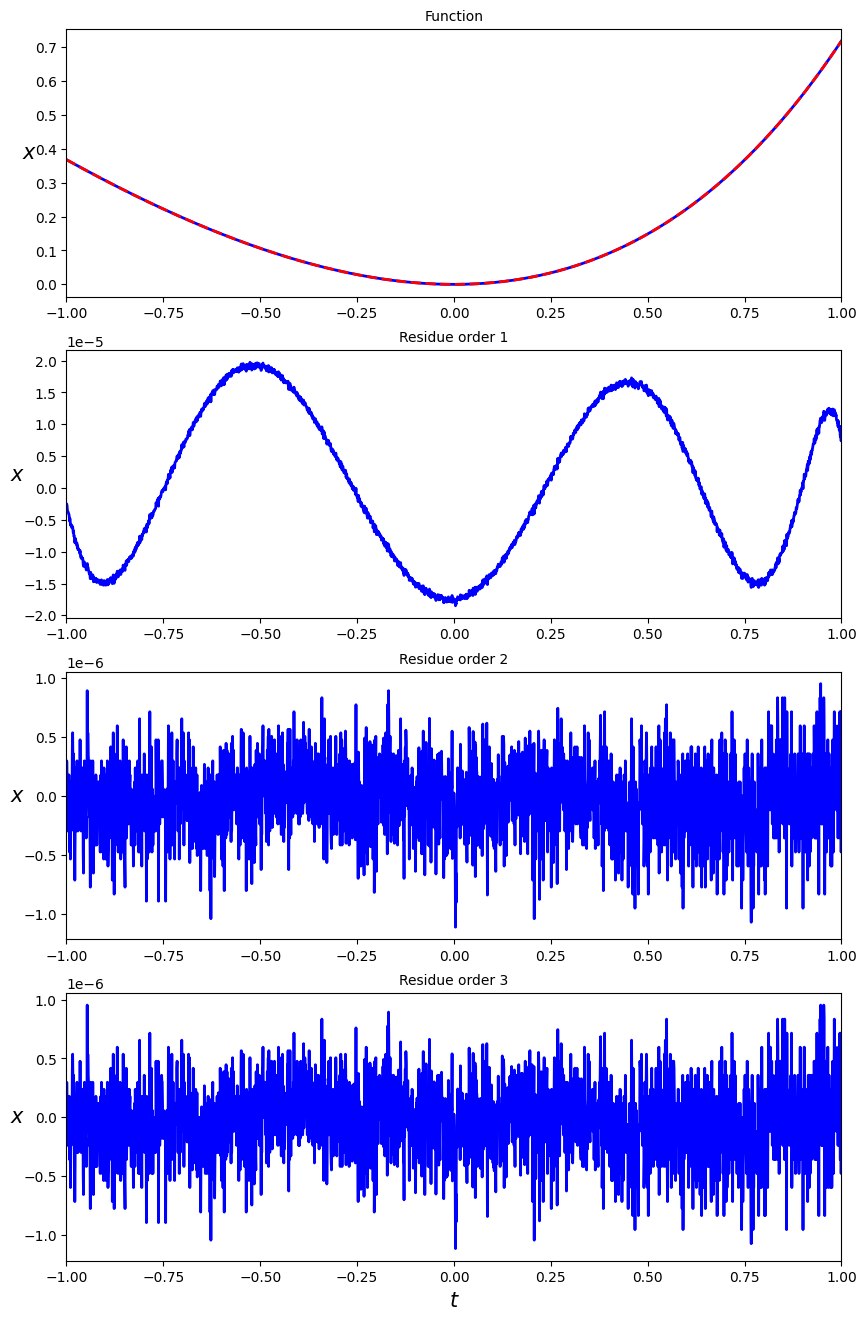

In [20]:
fig = plt.figure(figsize=[10, 16], dpi=100)

ax = plt.subplot(411)
ax.plot(x_star, fg(x_star), 'b-', linewidth = 2, label = 'Exact')
ax.plot(x_star, u3_p, 'r--', linewidth = 2, label = 'NN')
ax.set_ylabel('$x$', fontsize=15, rotation = 0)
ax.set_title('Function', fontsize=10)
ax.set_xlim([-1, 1])

ax1 = plt.subplot(412)
ax1.plot(x_star, f1_p, 'b-', linewidth=2, label='Exact')
ax1.set_ylabel('$x$', fontsize=15, rotation=0)
ax1.set_title('Residue order 1', fontsize=10)
ax1.set_xlim([-1.0, 1.0])


ax2 = plt.subplot(413)
ax2.plot(x_star, f2_p, 'b-', linewidth=2, label='Exact')
ax2.set_ylabel('$x$', fontsize = 15, rotation = 0)
ax2.set_title('Residue order 2', fontsize = 10)
ax2.set_xlim([-1.0, 1.0])


ax3 = plt.subplot(414)
ax3.plot(x_star, f3_p, 'b-', linewidth=2, label='Exact')
ax3.set_xlabel('$t$', fontsize = 15)
ax3.set_ylabel('$x$', fontsize = 15, rotation = 0)
ax3.set_title('Residue order 3', fontsize = 10)
ax3.set_xlim([-1.0, 1.0])

plt.show()